In [1]:
!pip -q install "transformers==4.48.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 109.2 MB/s eta 0:00:00


In [ ]:
!pip install -U huggingface_hub datasets

In [3]:
import os
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from itertools import chain
from datasets import load_from_disk, DatasetDict
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             cohen_kappa_score, accuracy_score, confusion_matrix)
from transformers import (AutoTokenizer, AutoConfig, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, DataCollatorWithPadding,
                          logging as hf_logging)

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors as mcolors
from matplotlib.patches import Rectangle


In [ ]:
!unzip "BAREC_dataSet_prepro_.zip"

In [ ]:
BAREC_dataSet =  load_from_disk("BAREC_dataSet_prepro_")

In [6]:
BAREC_dataSet

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 54845
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 7310
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 7286
    })
})

In [7]:
BAREC_dataSet["train"][0]


{'text': '[WC]5 [ANN]A2 [DOC]BAREC_Majed_0413_1987_001.txt [BOOK]Edition: 413 [AUTH]# [DOM]Arts & Humanities [TC]Foundational [DC]0.000 [WLA]4.400 [WLS]1.855 [SEP] مجلة كل الأولاد وكل البنات [SEP] مجلة كل الأولاد وكل البنات [SEP] مجلة كل ال+ أولاد و+ كل ال+ بنات [SEP] مجلة كل ال+ ولد و+ كل ال+ بنت',
 'labels': 7.0}

In [8]:
def selected_features(example):
    """Keep only metadata, Sentence, and D3Tok from the fused [SEP]-delimited text"""
    parts = example["text"].split(" [SEP] ")
    if len(parts) < 5:
        raise ValueError("Unexpected fused format — expected ≥4 segments.")
    example["text"] = f"{parts[0]} [SEP] {parts[1]} [SEP] {parts[3]}"   # originMetadata_statisticalIndicator + Raw_text (=Sentence) + D3Tok
    return example

dataset = BAREC_dataSet.map(
    selected_features,
    batched=False
    )

print(dataset["train"]["text"][0])

Map:   0%|          | 0/54845 [00:00<?, ? examples/s]

Map:   0%|          | 0/7310 [00:00<?, ? examples/s]

Map:   0%|          | 0/7286 [00:00<?, ? examples/s]

[WC]5 [ANN]A2 [DOC]BAREC_Majed_0413_1987_001.txt [BOOK]Edition: 413 [AUTH]# [DOM]Arts & Humanities [TC]Foundational [DC]0.000 [WLA]4.400 [WLS]1.855 [SEP] مجلة كل الأولاد وكل البنات [SEP] مجلة كل ال+ أولاد و+ كل ال+ بنات


In [9]:
hf_logging.set_verbosity_error()
CONFIG = {
    "model_name": "aubmindlab/bert-base-arabertv2",
    "output_dir": "phase1",
    "per_device_batch_size": 64,
    "gradient_accumulation_steps": 1,
    "num_train_epochs": 6,
    "learning_rate": 2e-5,
    "warmup_ratio": 0.1,
    "weight_decay": 0.01,
    "seed": 42,
    "fp16": False,
    "bf16": True,
    "max_length": 700,
}


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(CONFIG["model_name"])
SPECIAL_TOKENS = ["[WC]", "[ANN]", "[DOC]", "[BOOK]", "[AUTH]", "[DOM]",
                  "[TC]", "[DC]", "[WLA]", "[WLS]", "[SEP]"]
added = tokenizer.add_tokens(SPECIAL_TOKENS, special_tokens=False)
if added:
    print(f"Added {added} new special tokens.")

def tok_fn(batch):
    """Tokenize each input string in batch['text'] into IDs and attention masks, trimming to max_length."""
    return tokenizer(batch["text"], truncation=True, max_length=CONFIG["max_length"])

encoded   = dataset.map(tok_fn, batched=True, remove_columns=["text"])
collator  = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=8)

In [11]:
encoded

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 54845
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7310
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7286
    })
})

In [ ]:
encoded.save_to_disk("BAREC_dataSet_encoded")

In [12]:
# Load AraBERT for a regression task and align it with the tokenizer
cfg = AutoConfig.from_pretrained(
    CONFIG["model_name"], num_labels=1, problem_type="regression"
)
model = AutoModelForSequenceClassification.from_pretrained(
    CONFIG["model_name"], config=cfg
)
if added:
    model.resize_token_embeddings(len(tokenizer))

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

In [13]:
# --------------- diagnostics: longest fused sample -------------
all_fused   = list(chain.from_iterable(dataset[sp]["text"] for sp in dataset))
longest_seq = max(all_fused, key=len)
token_count = len(tokenizer.encode(longest_seq, add_special_tokens=True))
print(f"[DIAG] Longest fused sequence → {len(longest_seq)} chars, {token_count} tokens")


[DIAG] Longest fused sequence → 2326 chars, 686 tokens


In [14]:
# --------- (B) manual position-embedding extension -------------
def extend_position_embeddings(model, new_max_len: int = 768):
    """Extend position embeddings so the model can process sequences longer than
    its current max (e.g BERT's 512). Updates config and position_ids, New rows copy the last embedding and are learned during fine-tuning."""
    old_pos_emb = model.bert.embeddings.position_embeddings
    old_max_len, hidden = old_pos_emb.weight.shape
    if new_max_len <= old_max_len:
        return
    #Build new embedding matrix
    new_pos_emb = torch.nn.Embedding(new_max_len, hidden)
    new_pos_emb.weight.data[:old_max_len] = old_pos_emb.weight.data
    new_pos_emb.weight.data[old_max_len:] = old_pos_emb.weight.data[-1:].repeat(
        new_max_len - old_max_len, 1
    )
    # Replace and update config
    model.bert.embeddings.position_embeddings = new_pos_emb
    model.config.max_position_embeddings = new_max_len
    # Refresh the position_ids buffer to ensure it covers the new maximum length
    model.bert.embeddings.register_buffer(
        "position_ids", torch.arange(new_max_len).expand((1, -1)),
        persistent=False
    )

if CONFIG["max_length"] > model.config.max_position_embeddings:
    extend_position_embeddings(model, CONFIG["max_length"])
    tokenizer.model_max_length = CONFIG["max_length"]

In [15]:
def collapse(arr, div):
  """Group labels (e.g., 1–19) into bigger categories of size "div", in order to simplify accuracy metrics like Acc7, Acc5, or Acc3."""
  return ((arr - 1) // div) + 1

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.squeeze()
    metrics = {
        "MSE": mean_squared_error(labels, preds),
        "MAE": mean_absolute_error(labels, preds),
        "R2":  r2_score(labels, preds),
    }
    y_true = labels.astype(int)
    y_pred = np.rint(preds).clip(1, 19).astype(int)
    metrics.update({
        "QWK":       cohen_kappa_score(y_true, y_pred, weights="quadratic"),
        "AdjAcc19":  (np.abs(y_true - y_pred) <= 1).mean(),
        "Acc19":     accuracy_score(y_true, y_pred),
        "Acc7":      accuracy_score(collapse(y_true, 3), collapse(y_pred, 3)),
        "Acc5":      accuracy_score(collapse(y_true, 4), collapse(y_pred, 4)),
        "Acc3":      accuracy_score(collapse(y_true, 7), collapse(y_pred, 7)),
    })
    return metrics


In [ ]:
MODEL_DIR = None
args = TrainingArguments(
    output_dir=CONFIG["output_dir"],
    evaluation_strategy="epoch",
    eval_on_start=True,
    save_strategy="epoch",
    metric_for_best_model="eval_QWK",
    greater_is_better=True,
    per_device_train_batch_size=CONFIG["per_device_batch_size"],
    per_device_eval_batch_size=CONFIG["per_device_batch_size"],
    gradient_accumulation_steps=CONFIG["gradient_accumulation_steps"],
    num_train_epochs=CONFIG["num_train_epochs"],
    learning_rate=CONFIG["learning_rate"],
    warmup_ratio=CONFIG["warmup_ratio"],
    weight_decay=CONFIG["weight_decay"],
    fp16=CONFIG["fp16"],
    bf16=CONFIG["bf16"],
    logging_dir=os.path.join(CONFIG["output_dir"], "logs"),
    seed=CONFIG["seed"],
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="wandb",
    run_name=Path(CONFIG["output_dir"]).name,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=encoded["train"],
    eval_dataset=encoded["validation"],
    data_collator=collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


In [17]:
if MODEL_DIR is None:
    print("\n[INFO] Training ⏳ …\n")
    trainer.train()
    trainer.save_model(CONFIG["output_dir"])
    print("\n✅ Best model saved to:", CONFIG["output_dir"])
else:
    print(f"[INFO] Skipping training – loading {MODEL_DIR}")


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.



[INFO] Training ⏳ …



/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: trigui-yasan (trigui-yasan-paris) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'eval_loss': 113.83736419677734, 'eval_MSE': 113.83736419677734, 'eval_MAE': 10.131304740905762, 'eval_R2': -9.014153480529785, 'eval_QWK': 0.0, 'eval_AdjAcc19': 0.015321477428180574, 'eval_Acc19': 0.006019151846785226, 'eval_Acc7': 0.04021887824897401, 'eval_Acc5': 0.05088919288645691, 'eval_Acc3': 0.22968536251709987, 'eval_runtime': 5.1534, 'eval_samples_per_second': 1418.47, 'eval_steps_per_second': 22.315, 'epoch': 0}
{'loss': 34.3929, 'grad_norm': 82.82444763183594, 'learning_rate': 1.9417475728155343e-05, 'epoch': 0.5834305717619603}
{'eval_loss': 4.031022071838379, 'eval_MSE': 4.031022071838379, 'eval_MAE': 1.4775521755218506, 'eval_R2': 0.6453952193260193, 'eval_QWK': 0.8092334207839988, 'eval_AdjAcc19': 0.606155950752394, 'eval_Acc19': 0.27551299589603284, 'eval_Acc7': 0.5708618331053351, 'eval_Acc5': 0.6454172366621067, 'eval_Acc3': 0.8129958960328317, 'eval_runtime': 4.3815, 'eval_samples_per_second': 1668.384, 'eval_steps_per_second': 26.247, 'epoch': 1.0}
{'loss': 3.8447

In [ ]:
!zip -r "phase1_checkpoint-3428_epcoh4_evalQWK_84.zip" "phase1"

**Inference**

In [22]:
dataset["test"][0]

{'text': '[WC]1 [ANN]A2 [DOC]BAREC_Majed_1686_2011_001.txt [BOOK]Edition: 1686 [AUTH]# [DOM]Arts & Humanities [TC]Foundational [DC]0.000 [WLA]4.000 [WLS]0.000 [SEP] ماجد [SEP] ماجد',
 'labels': 1.0}

In [23]:
print(encoded["test"][0])

{'labels': 1.0, 'input_ids': [33, 64000, 50, 64001, 58440, 64002, 26756, 28869, 264, 95, 44360, 49090, 232, 95, 59350, 95, 2517, 95, 41146, 48, 116, 40824, 64003, 58480, 59, 59350, 64004, 38, 64005, 33716, 191, 32, 49672, 41602, 64006, 55875, 4943, 64007, 49, 48, 4619, 206, 64008, 53, 48, 4619, 206, 64009, 49, 48, 4619, 206, 34, 3999, 34, 3999, 34], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [27]:
pred = trainer.predict(encoded["test"])

In [28]:
pred.metrics

{'test_loss': 2.838550090789795,
 'test_MSE': 2.838550090789795,
 'test_MAE': 1.18567955493927,
 'test_R2': 0.7329058647155762,
 'test_QWK': 0.8525246430794235,
 'test_AdjAcc19': 0.7239912160307439,
 'test_Acc19': 0.3493000274499039,
 'test_Acc7': 0.6496019763930826,
 'test_Acc5': 0.715344496294263,
 'test_Acc3': 0.8657699698051057,
 'test_runtime': 4.5821,
 'test_samples_per_second': 1590.107,
 'test_steps_per_second': 24.88}

**Analysis**

In [29]:
def plot_confusion_matrix(cm, labels, title, save_path, vmax=None, normed=False):
    plt.figure(figsize=(8,6))
    if vmax is None:
        vmax = cm.max()
    norm = mcolors.PowerNorm(gamma=0.5, vmin=0.0, vmax=vmax)
    ax = sns.heatmap(cm,
                     cmap="turbo",
                     xticklabels=labels,
                     yticklabels=labels,
                     norm=norm,
                     cbar=True,
                     annot=False)
    n = cm.shape[0]
    for i in range(n):
        ax.add_patch(Rectangle((i, i), 1, 1, fill=False,
                               edgecolor="white", linewidth=0.9, alpha=0.7))
    ax.set_xlabel("Predicted (rounded)")
    ax.set_ylabel("True")
    ax.set_title(title)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()


=== Test Metrics ===
       MSE: 2.838550
       MAE: 1.185680
        R2: 0.732906
       QWK: 0.852525
  AdjAcc19: 0.723991
     Acc19: 0.349300
      Acc7: 0.649602
      Acc5: 0.715344
      Acc3: 0.865770

Saved predictions to: out-infer/figs/test_predictions.csv


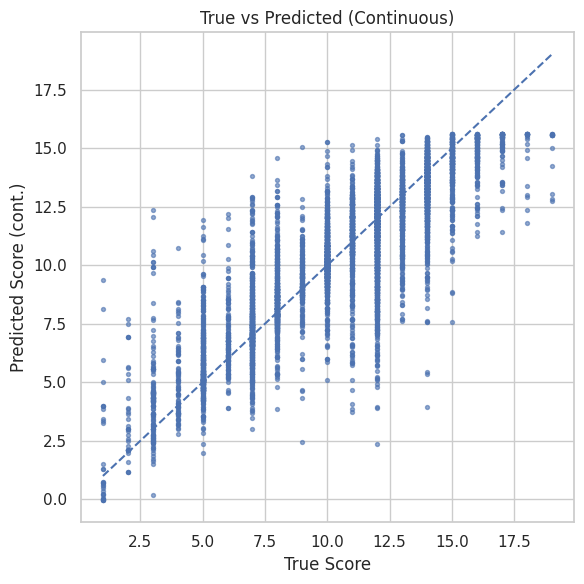

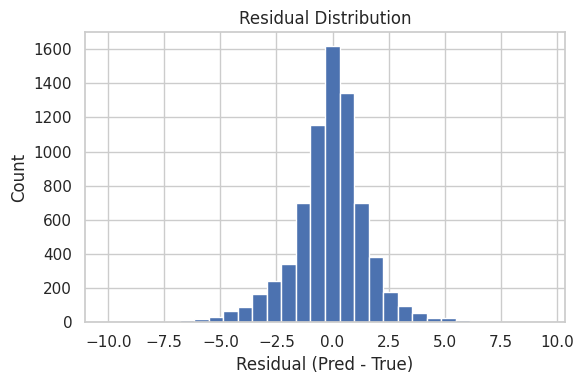

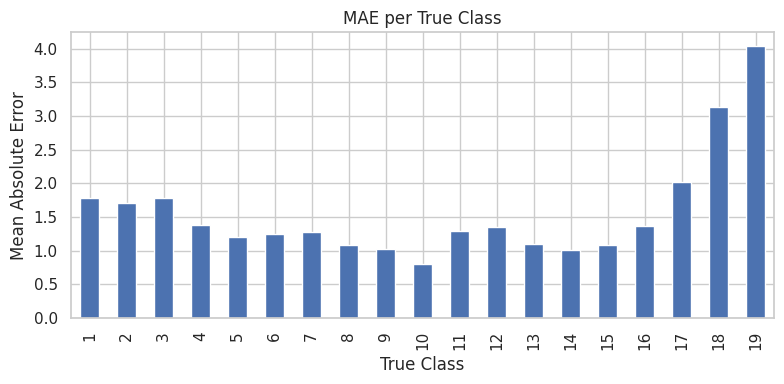

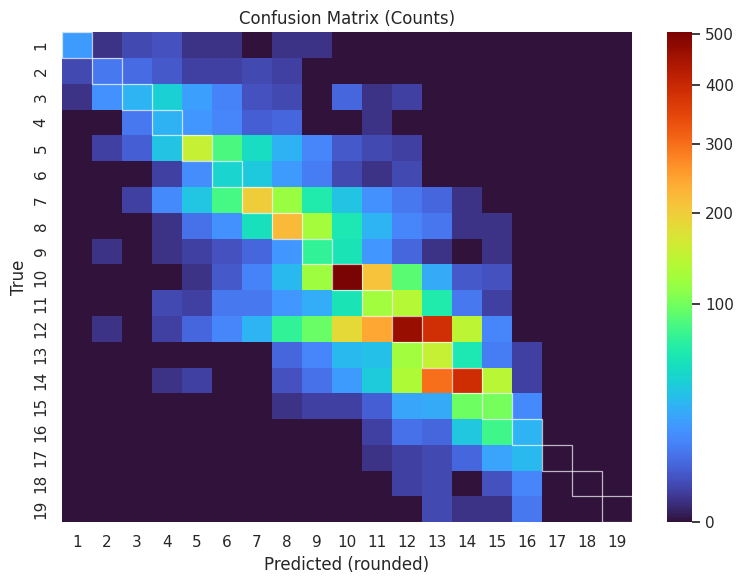

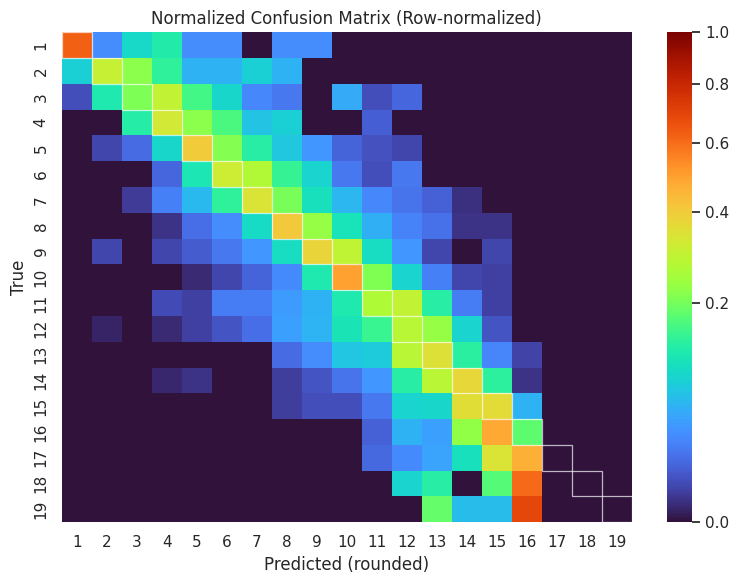

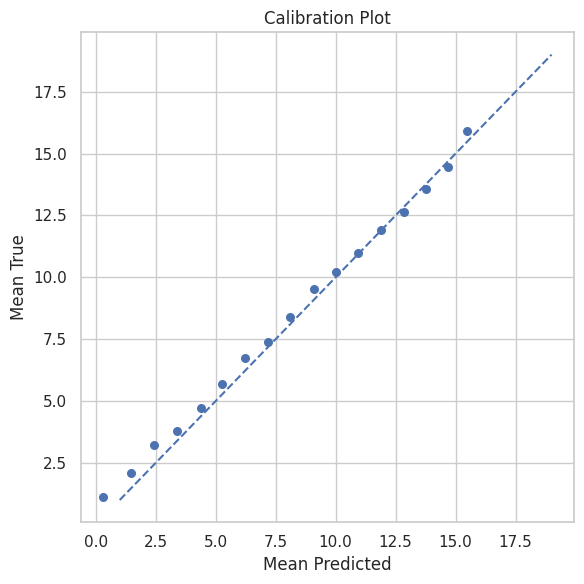

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

In [30]:
OUT_DIR = Path("plots")
FIG_DIR = Path("out-infer/figs")
FIG_DIR.mkdir(parents=True, exist_ok=True)

MIN_R, MAX_R = 1, 19
LABELS = list(range(MIN_R, MAX_R + 1))
pred_output = pred
logits = pred_output.predictions.squeeze(-1)
y_true = np.array(encoded["test"]["labels"], dtype=np.float32)
y_pred_cont = logits
y_pred_disc = np.rint(y_pred_cont).clip(MIN_R, MAX_R)
metrics = compute_metrics((y_pred_cont, y_true))
print("=== Test Metrics ===")
for k, v in metrics.items():
    print(f"{k:>10}: {v:.6f}")

df = pd.DataFrame({
    "y_true"     : y_true,
    "y_pred"     : y_pred_cont,
    "y_pred_int" : y_pred_disc,

    "abs_err"    : np.abs(y_true - y_pred_cont),
    "int_err"    : (y_true - y_pred_disc)
})
csv_path = FIG_DIR / "test_predictions.csv"
df.to_csv(csv_path, index=False)
print(f"\nSaved predictions to: {csv_path}")
sns.set(style="whitegrid")

#True vs Pred
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred_cont, s=8, alpha=0.6)
plt.plot([MIN_R, MAX_R], [MIN_R, MAX_R], "--")
plt.xlabel("True Score")
plt.ylabel("Predicted Score (cont.)")
plt.title("True vs Predicted (Continuous)")
plt.tight_layout()
plt.savefig(FIG_DIR / "scatter_true_vs_pred.png", dpi=300)
plt.show()

#Residual histogram
residuals = y_pred_cont - y_true
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.xlabel("Residual (Pred - True)")
plt.ylabel("Count")
plt.title("Residual Distribution")
plt.tight_layout()
plt.savefig(FIG_DIR / "residual_hist.png", dpi=300)
plt.show()

#MAE per true class
ae_by_class = df.groupby(df.y_true.astype(int))["abs_err"].mean()
plt.figure(figsize=(8,4))
ae_by_class.plot(kind="bar")
plt.xlabel("True Class")
plt.ylabel("Mean Absolute Error")
plt.title("MAE per True Class")
plt.tight_layout()
plt.savefig(FIG_DIR / "mae_per_class.png", dpi=300)
plt.show()

#Confusion matrix
cm = confusion_matrix(y_true.astype(int), y_pred_disc.astype(int), labels=LABELS)
plot_confusion_matrix(cm, LABELS,
                      title="Confusion Matrix (Counts)",
                      save_path=FIG_DIR / "confusion_matrix_counts.png",
                      vmax=cm.max(),
                      normed=False)

#Normalized confusion matrix (rows sum to 1)
cm_norm = confusion_matrix(y_true.astype(int), y_pred_disc.astype(int),
                           labels=LABELS, normalize="true")
plot_confusion_matrix(cm_norm, LABELS,
                      title="Normalized Confusion Matrix (Row-normalized)",
                      save_path=FIG_DIR / "confusion_matrix_normalized.png",
                      vmax=1.0,
                      normed=True)

#Calibration plot
bins = np.linspace(MIN_R, MAX_R, 20)
bin_ids = np.digitize(y_pred_cont, bins)
calib = pd.DataFrame({"bin": bin_ids, "y_true": y_true, "y_pred": y_pred_cont}) \
            .groupby("bin").mean().dropna()
plt.figure(figsize=(6,6))
plt.scatter(calib["y_pred"], calib["y_true"], s=30)
plt.plot([MIN_R, MAX_R], [MIN_R, MAX_R], "--")
plt.xlabel("Mean Predicted")
plt.ylabel("Mean True")
plt.title("Calibration Plot")
plt.tight_layout()
plt.savefig(FIG_DIR / "calibration_plot.png", dpi=300)
plt.show()

#Absolute error distribution per true class
df["true_bin"] = df["y_true"].astype(int)
plt